## ShearView Op

In [1]:
//load ImageJ
%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-67

//create ImageJ object
ij = new net.imagej.ImageJ()

Added new repo: scijava.public


net.imagej.ImageJ@7b00c550

This `Op` wraps the `Views.stack()` method of ImgLib2, [shearing](https://en.wikipedia.org/wiki/Shear_mapping) a `RandomAccessible` in a given dimension (using a second dimension as reference). This `Op` shears **in the opposite direction** of [`unshearView`](unshearView.ipynb), and can be used to undo the shears from that `Op`. Let's take a look at how it is called:

In [2]:
ij.op().help('shearView')

Available operations:
	(TransformView out) =
	net.imagej.ops.transform.shearView.DefaultShearView(
		RandomAccessible in,
		int shearDimension,
		int referenceDimension)
	(IntervalView out) =
	net.imagej.ops.transform.shearView.ShearViewInterval(
		RandomAccessible in,
		Interval interval,
		int shearDimension,
		int referenceDimension)

Let's take a closer look at each parameter:
* `RandomAccessible in`: the input image
* `Interval interval`: an **optional** parameter that defines a region on the `RandomAccessible` that we want to shear, and allows the `Op` to return an minimal `Interval` containing all of the pixels on the original `Interval`, although of course not the same size as before. If you originally are starting with a `RandomAccessibleInterval`, it is probably best to include this interval. We are going to use it in the notebooks, since displaying a `RandomAccessible` not on an `Interval` is harder.
* `int shearDimension`: the dimension whose coordinates will change based on `referencedimension`.
* `int referenceDimension`: the dimension whose coordinates will not change but will influence `shearDimension`.

So, let's say that `shearDimension` is `0` and `referenceDimension` is `1`. This will cause `(x, y)` to become `(x + y, x)`. Let's see what this looks like visually with an image:

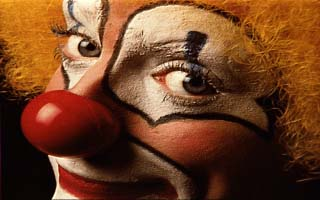

In [3]:
input = ij.scifio().datasetIO().open("http://imagej.net/images/clown.png")

ij.notebook().display(input)

Note that shearing an `Img` can be dangerous since most `Img`s are `RandomAccessibleInterval`s, not `RandomAccessible`s. In layman's terms, `RandomAccessibleInterval`s are not defined for coordinates outside its `Interval`, and as such errors will be thrown if we, for example, attempt to access a data value at negative coordinates. There are two ways that we can get around this error with `shearView`:
1. Convert our `RandomAccessibleInterval` into a `RandomAccessible` through the use of `extendView` or any other extending `Op`s. This will provide values at all locations, preventing any sort of issue with bounds. However this means another `Op` call that we have to write to extend our `Img`, and then if we want to display the output (which will also be a `RandomAccessible`) we will have to create another `Interval` over the output.
2. Provide an `Interval` (usually our input `Img`) to our `Op`: as stated above, if we provide an `Interval` the `Op` will do most of the problem solving for us at the cost of customizability on the user's behalf. The `Op` will calculate an outuput `Interval` and will use its own default `OutOfBoundsFactory`, which we may or may not want. 

We will show both options below, to provide an example of each:

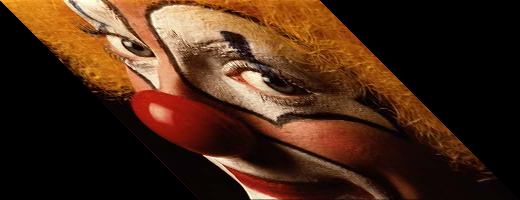

In [4]:
//FIRST OPTION
import net.imglib2.FinalInterval
import net.imglib2.view.Views

shearDimension = 0
referenceDimension = 1

//Maybe we want all of the pixels outside the original interval to have a value of zero
extended = ij.op().run("extendZeroView", input)
sheared = ij.op().run("shearView", extended, shearDimension, referenceDimension)

//since (x,y) => (x + y, y), our size will be (width + height, height, numChannels) (and the min is (0, 0, 0))
outputInterval = FinalInterval.createMinSize(0, 0, 0, input.dimension(0) + input.dimension(1), input.dimension(1), 3)
outputIntervaled = Views.interval(sheared, outputInterval)

ij.notebook().display(outputIntervaled)

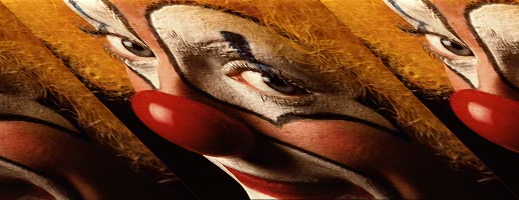

In [5]:
//SECOND OPTION

//let the Op do all the work that we did above
sheared = ij.op().run("shearView", input, input, shearDimension, referenceDimension)

ij.notebook().display(sheared)

Note that the second option decided that we wanted to extend our `Interval` using [`extendPeriodicView`](extendPeriodicView.ipynb), however if for some reason this would not be desired, then the first option, although more code, is preferable.